# Overview of the notebook:

We will analyse the data of MLP-T1-2024 discourse engagement and try to understand the engagement of the participants. First we will fetch the data using APIs and then we will analyse the data using various plots and graphs. We will use various normalization techniques and then compare the results.

# Why normalization?

**Normalizing the features before applying weights is generally a good practice**, especially when the features have different scales (e.g., *likes_given* could range in the hundreds while *solutions_posted* might be in the tens). If the features are not normalized, features with large values will dominate the final engagement score, making the weighting ineffective.

---

## **Normalization Techniques:**
### 1. **Min-Max Scaling (Feature Scaling)**
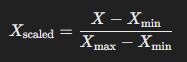
- **Effect**: Transforms values between 0 and 1.
- **Pros**: Retains relative distances and original distribution.
- **Cons**: Sensitive to outliers (as they define \(X_{\text{max}}\) and \(X_{\text{min}}\)).
- **Best Use Case**: When all features should contribute proportionally and you want scores in a fixed range (0-1).

### 2. **Z-score Normalization (Standardization)**
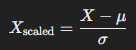
- **Effect**: Transforms data to have a mean of 0 and standard deviation of 1.
- **Pros**: Good for normally distributed data and less sensitive to outliers.
- **Cons**: Doesn’t bound values to a fixed range.
- **Best Use Case**: When features have different units and you need them to have comparable variation.

### 3. **Log Transformation**
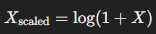
- **Effect**: Reduces skewness in data (useful for features with a long tail, like likes_received).
- **Pros**: Handles large variations in values well.
- **Cons**: Not effective when data has negative values or zeroes.
- **Best Use Case**: When engagement metrics follow a power-law distribution (few users contribute a lot, many contribute little).

### 4. **Robust Scaling**
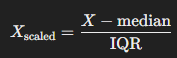
- **Effect**: Normalizes based on median and interquartile range (IQR).
- **Pros**: Robust to outliers.
- **Cons**: Doesn’t strictly force values into a specific range.
- **Best Use Case**: When the dataset has extreme outliers.

---

## **Which Normalization to Choose?**

- **Min-Max Scaling** if you want a final score in a fixed range (0-1).
- **Z-score Normalization** if your engagement metrics vary significantly and need standardization.
- **Log Transformation** if the distribution is skewed (e.g., a few users getting hundreds of likes while most get very few).
---
- If engagement data has extreme outliers, consider Robust Scaling.  
- Otherwise, Min-Max Scaling is usually the most interpretable choice.
- If the distribution is highly skewed, we might prefer log transformation.

In [31]:
import pandas as pd
import numpy as np
import time, json, requests, yaml

# Step 1: Getting the data for MLP-T1-2024

In [ ]:
with open("../key.yaml", "r") as file:
    api_keys = yaml.safe_load(file)

def execute_query(query_id, query_params=None):
    DISCOURSE_BASE_URL = "https://discourse.onlinedegree.iitm.ac.in"
    GROUP_NAME = "discourse_analytics"
    API_KEY_GLOBAL= api_keys["API_KEY"]
    API_USERNAME = 'shubhamG'

    iteration_count = 0  # Initialize iteration counter
    results_list = []  # List to store results
    has_more_results = True  # Flag to control the loop for pagination

    # Check if query_params is provided
    if query_params is None:
        pass  # No parameters provided, continue with default
    else:
        # Ensure query_params is a dictionary
        if not isinstance(query_params, dict):
            raise ValueError("Query parameters must be a dictionary.")

    # Set up headers for the API request
    headers = {
        "Accept": "*/*",
        "Api-Key": API_KEY_GLOBAL,  # Get API key from userdata
        "Api-Username": API_USERNAME,  # Set the username for the API
        "Content-Type": "multipart/form-data"  # Set content type
    }

    # Loop until there are no more results
    while has_more_results:
        # Construct the request URL for the API
        request_url = f"{DISCOURSE_BASE_URL}/g/{GROUP_NAME}/reports/{query_id}/run"

        # Prepare the data payload for the request
        if query_params is not None:
            payload = {'page': str(iteration_count)}  # Add page number to payload
            payload.update(query_params)  # Update payload with additional query parameters
            data_payload = 'params=' + json.dumps(payload)  # Convert payload to JSON string
        else:
            data_payload = f'params={{"page": "{iteration_count}"}}'  # Default payload with page number

        try:
            # Send POST request to the API
            # print(data_payload)
            response = requests.request("POST", request_url, data=data_payload, headers=headers)
            response.raise_for_status()  # Raise an error for bad responses

            json_response = response.json()  # Parse the JSON response

            # Check if there are no results
            if json_response["result_count"] == 0:
                has_more_results = False  # No more results to fetch
                break

            # Iterate over the rows in the response
            for index in range(len(json_response['rows'])):
                # Append each row as a dictionary to the results list
                results_list.append(dict(zip(json_response['columns'], json_response['rows'][index])))

        except requests.exceptions.RequestException as e:
            # Log request-related errors
            # logging.error(f'Request error: {e}')
            if hasattr(e, 'response') and e.response is not None:
                print(f'Status code: {e.response.status_code}')  # Log status code
                print(f'Error text: {e.response.text}')  # Log error text

            has_more_results = False  # Stop fetching results
            break
        except ValueError as e:
            # Log JSON parsing errors
            print(f'Error parsing JSON: {e}')
            has_more_results = False  # Stop fetching results
            break
        except KeyError as e:
            # Log key-related errors
            print(f'Key error: {e}')
            has_more_results = False  # Stop fetching results
            break

        iteration_count += 1  # Increment iteration count for pagination
        time.sleep(1.4)  # Wait before the next request

    results_dataframe = pd.DataFrame(results_list)  # Convert results list to DataFrame
    return results_dataframe  # Return the DataFrame with results

params = {"category_id":"33","start_date":"22/01/2024","end_date":'28/04/2024'}
req_data = execute_query(query_id=103,query_params=params)
req_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5317 entries, 0 to 5316
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   created_at       5317 non-null   object
 1   user_id          5317 non-null   int64 
 2   action_type      5317 non-null   int64 
 3   target_user_id   0 non-null      object
 4   target_topic_id  5317 non-null   int64 
 5   target_post_id   5317 non-null   int64 
 6   topic_title      5317 non-null   object
 7   acting_username  5317 non-null   object
 8   action_name      5317 non-null   object
dtypes: int64(4), object(5)
memory usage: 374.0+ KB


# Step 2: Getting info about the data and processing it

In [2]:
req_data.columns

Index(['created_at', 'user_id', 'action_type', 'target_user_id',
       'target_topic_id', 'target_post_id', 'topic_title', 'acting_username',
       'action_name'],
      dtype='object')

In [3]:
req_data.head()

,created_at,user_id,action_type,target_user_id,target_topic_id,target_post_id,topic_title,acting_username,action_name
0,2024-04-27T22:23:29.891Z,14364,2,None,127493,461035,Gridsearchcv multiply with cv,22f2001362,was_liked
1,2024-04-27T22:23:29.891Z,5480,1,None,127493,461035,Gridsearchcv multiply with cv,suhas26,like
2,2024-04-27T19:36:48.607Z,14443,6,None,127500,462252,MLP End Term PYQ,22f2001236,response
3,2024-04-27T19:36:48.497Z,8750,5,None,127500,462252,MLP End Term PYQ,21f3002305,reply
4,2024-04-27T19:25:35.076Z,8750,6,None,127500,462250,MLP End Term PYQ,21f3002305,response


In [4]:
req_data["action_type"].value_counts()

action_type
6     1330
5     1220
2      795
1      793
7      510
4      423
11     150
15      93
9        2
17       1
Name: count, dtype: int64

In [5]:
req_data["action_name"].value_counts() # To confirm if the action_type is correctly mapped to action_name

action_name
response     1330
reply        1220
was_liked     795
like          793
mention       510
new_topic     423
edit          150
other          94
quote           2
Name: count, dtype: int64

In [6]:
action_to_description = {
"1": "likes_given",
"2": "likes_received",
"3": "bookmarked_post",
"4": "created_new_topic",
"5": "replied",
"6": "received_response",
"7": "user_was_mentioned",
"9": "user's_post_quoted",
"11": "user_edited_post",
"12": "user_sent_private_message",
"13": "recieved_a_private_message",
"15": "solved_a_topic",
"16": "user_was_assigned",
"17": "linked"
}
# Change the values in action_name column based on values of action_type and map it via the action_to_description dictionary. This is done to make the column_names more intuitive to understand.
req_data['action_type'] = req_data['action_type'].astype(str)
req_data['action_name'] = req_data['action_type'].map(action_to_description)
req_data.head()

,created_at,user_id,action_type,target_user_id,target_topic_id,target_post_id,topic_title,acting_username,action_name
0,2024-04-27T22:23:29.891Z,14364,2,None,127493,461035,Gridsearchcv multiply with cv,22f2001362,likes_received
1,2024-04-27T22:23:29.891Z,5480,1,None,127493,461035,Gridsearchcv multiply with cv,suhas26,likes_given
2,2024-04-27T19:36:48.607Z,14443,6,None,127500,462252,MLP End Term PYQ,22f2001236,received_response
3,2024-04-27T19:36:48.497Z,8750,5,None,127500,462252,MLP End Term PYQ,21f3002305,replied
4,2024-04-27T19:25:35.076Z,8750,6,None,127500,462250,MLP End Term PYQ,21f3002305,received_response


In [7]:
df = pd.crosstab(req_data["acting_username"], req_data["action_name"]) # Pivot table
df.head(6)

action_name,created_new_topic,likes_given,likes_received,linked,received_response,replied,solved_a_topic,user's_post_quoted,user_edited_post,user_was_mentioned
acting_username,,,,,,,,,,
21f1000196,2,4,4,0,8,4,1,0,0,0
21f1000323,1,0,0,0,1,0,0,0,0,0
21f1001712,0,2,3,0,4,7,0,0,0,1
21f1002499,1,0,0,0,0,0,0,0,0,0
21f1002877,0,0,0,0,0,1,0,0,0,0
21f1003954,3,2,6,0,16,3,0,0,0,1


In [8]:
columns_to_be_dropped = ['linked','received_response', "user's_post_quoted",
       'user_edited_post', 'user_was_mentioned'] # dropping columns which are not required for analysis
df.drop(columns_to_be_dropped, axis=1, inplace=True)
print(df.columns)

Index(['created_new_topic', 'likes_given', 'likes_received', 'replied',
       'solved_a_topic'],
      dtype='object', name='action_name')


In [9]:
# Print unique values of all feature columns
for col in df.columns:
    if col not in ['z_score', "username", "initial_score"]:
        print(f"{col}: {sorted((df[col].unique()).tolist())}")
# We can see that all the features have less number of unique values, and for all of them, the last few unique values are much larger than the rest. This suggests that these are outliers and a potential skewness in the data.

created_new_topic: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 19, 20, 25, 33]
likes_given: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 22, 28, 32, 33, 35, 71]
likes_received: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 20, 24, 27, 29, 34, 37, 40, 67]
replied: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 23, 24, 26, 27, 37, 52, 53, 69, 88, 111]
solved_a_topic: [0, 1, 2, 3, 4, 5, 6, 10, 11, 12]


# Step 3: Visualizing the distribution of the features

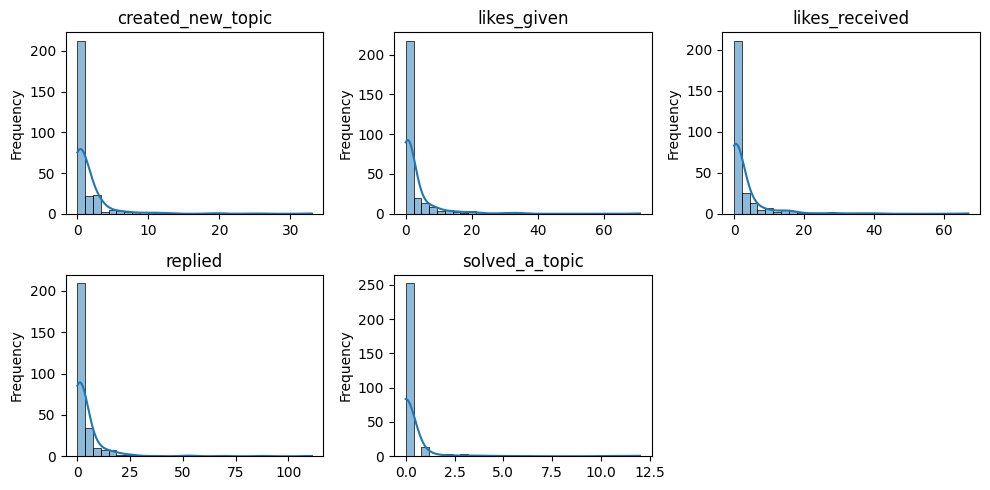

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
# Select only numeric features (modify if needed)
features = ['created_new_topic', 'likes_given', 'likes_received', 'replied', 'solved_a_topic']

# Set up subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,5))  # Adjust grid size if needed
axes = axes.flatten()

# Plot distributions
for i, feature in enumerate(features):
    sns.histplot(df[feature], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f"{feature}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frequency")

# Hide any unused subplot spaces
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### **Critical Analysis of the Distribution Plot**  
Looking at the histograms and KDE plots for each feature, here are some key observations:

---

### **1. The Data is Highly Right-Skewed**
- **All features** (likes_given, likes_received, created_a_new_topic, replied, etc.) show a strong right-skewed (positively skewed) distribution.
- This means most users have very low values, but a few users have extremely high values.
- **Implication**: If we apply Min-Max Scaling or Z-score Normalization directly, the large values will dominate, making the scale uneven.

**Conclusion:** **Log Transformation is likely the best normalization technique** for this dataset.  
It will reduce the impact of extreme values and make the distribution more symmetric.

---

### **2. Presence of Heavy-Tailed Distributions**
- The histograms suggest that a small number of users contribute a **disproportionate** number of interactions (likes, replies, solutions).
- This is common in community-driven platforms where **super-users** (highly active members) dominate engagement.
- **Insights**:  
  - Instead of treating all users equally in engagement scoring, we may need a **segmented approach**.
  - For example, we may want to separate **"normal users"** from **"super-users"** when defining engagement levels.

We may slso consider applying **Robust Scaling** as an alternative normalization technique, since it is less affected by outliers.

---

### **Final Recommendations on Normalization:**
| **Normalization Technique**  | **Why Use It?**  | **Best Features to Apply It To**  |
|------------------------------|------------------|----------------------------------|
| **Log Transformation**       | Handles right-skewed data | All engagement metrics (likes, replies, solutions, etc.) |
| **Robust Scaling**           | Reduces the impact of extreme values (outliers) | All features, but especially "likes_received" and "replies" |
| **Min-Max Scaling**          | Good for fixed-range scoring (0-1) but sensitive to outliers | If outliers are removed first |
| **Binary Encoding** (0 or 1) | For highly sparse features (many zeroes) | "User's post was quoted", "solutions posted" |

In [83]:
df.head()

action_name,created_new_topic,likes_given,likes_received,replied,solved_a_topic
acting_username,,,,,
21f1000196,2,4,4,4,1
21f1000323,1,0,0,0,0
21f1001712,0,2,3,7,0
21f1002499,1,0,0,0,0
21f1002877,0,0,0,1,0


In [11]:
mlp_dataframe = df.copy()
mlp_dataframe['acting_username'] = mlp_dataframe.index # Changing the index to a column
mlp_dataframe = mlp_dataframe[["acting_username"]+[col for col in mlp_dataframe.columns if col != 'acting_username']]  # Reordering the columns
mlp_dataframe.index = range(0, len(mlp_dataframe))
mlp_dataframe.columns.name = None
mlp_dataframe.to_excel('NEW_mlp_dataframe.xlsx', index=False) # Save in a excel file
mlp_dataframe.head()

,acting_username,created_new_topic,likes_given,likes_received,replied,solved_a_topic
0,21f1000196,2,4,4,4,1
1,21f1000323,1,0,0,0,0
2,21f1001712,0,2,3,7,0
3,21f1002499,1,0,0,0,0
4,21f1002877,0,0,0,1,0


# Step 4: Calculating normalized scores

In [ ]:
# Assign the weights to the relevant columns. This can be changed as per the requirement.
weights_dict = { 'likes_given': 0.3, # 0.3
                "likes_received": 0.8, # changed from 0.7
                "created_new_topic": 0.5, # changed from 1.0
                "replied": 0.7,
                'solved_a_topic': 1
}
columns_to_be_ignored = ["initial_score",'username','overall_topics_count_of_this_subject', 'normalised_score', 'z_score', "acting_username"] # this was directly taken from previous notebook. Some column names might seem irrelevant. Please ignore them.

numerical_features = mlp_dataframe.select_dtypes(include=['number']).columns

def calculate_scores(df):
    df["initial_score"] = sum(df[column]*weights_dict[column] for column in df.columns if column not in columns_to_be_ignored) # Initial score = sum(column_value*weight)

    df["z_score"] = round((df["initial_score"] - df["initial_score"].mean()) / df["initial_score"].std(),2) # z_score rounded to 2 decimal places
    return df

## Unnormalized scores (for reference)

In [26]:
unnormalized_dataframe = mlp_dataframe.copy()
unnormalized_dataframe = calculate_scores(unnormalized_dataframe)
unnormalized_final_scores = unnormalized_dataframe[["acting_username", "initial_score", "z_score"]] # Selecting only a subset of columns for easier comparison
unnormalized_final_scores[unnormalized_final_scores["z_score"] > 2].sort_values(by="z_score",ascending=False)

,acting_username,initial_score,z_score
236,iitmanupam,155.3,9.38
180,PremKumarGupta,108.2,6.40
226,dev_22f2000888,83.9,4.86
196,Soni,82.9,4.79
184,Rajeev_kumar_bhagat,67.4,3.81
83,22f2001362,48.1,2.59
210,aaruni-kale,46.3,2.47
249,man,45.5,2.42


## Log normalization

In [ ]:
# Apply log normalization to the numerical features
log_normalized_dataframe = mlp_dataframe.copy()
for feature in numerical_features:
    log_normalized_dataframe[feature] = round(np.log1p(log_normalized_dataframe[feature]),3)
log_normalized_dataframe.head()

,acting_username,created_new_topic,likes_given,likes_received,replied,solved_a_topic
0,21f1000196,1.099,1.609,1.609,1.609,0.693
1,21f1000323,0.693,0.000,0.000,0.000,0.000
2,21f1001712,0.000,1.099,1.386,2.079,0.000
3,21f1002499,0.693,0.000,0.000,0.000,0.000
4,21f1002877,0.000,0.000,0.000,0.693,0.000


In [ ]:
log_normalized_dataframe.describe().loc[['min', 'max']] # Print the range (min-max) of each numerical column. We can see that range of all columns is much more comparable now.

,created_new_topic,likes_given,likes_received,replied,solved_a_topic
min,0.000,0.000,0.00,0.000,0.000
max,3.526,4.277,4.22,4.718,2.565


In [23]:
log_normalized_dataframe = calculate_scores(log_normalized_dataframe)
log_normalized_final_scores = log_normalized_dataframe[["acting_username", "initial_score", "z_score"]]
log_normalized_final_scores.head()

,acting_username,initial_score,z_score
0,21f1000196,4.1387,1.12
1,21f1000323,0.3465,-0.76
2,21f1001712,2.8938,0.50
3,21f1002499,0.3465,-0.76
4,21f1002877,0.4851,-0.69


In [25]:
log_normalized_final_scores[log_normalized_final_scores["z_score"]>2].sort_values(by="z_score",ascending=False)
# Much more users now. Some of them can be potential TAs/mentors

,acting_username,initial_score,z_score
236,iitmanupam,11.1348,4.58
180,PremKumarGupta,9.6487,3.84
226,dev_22f2000888,9.2012,3.62
196,Soni,9.0801,3.56
184,Rajeev_kumar_bhagat,8.1591,3.11
92,22f3001311,7.1274,2.60
83,22f2001362,6.8599,2.46
210,aaruni-kale,6.8286,2.45
249,man,6.7900,2.43
224,chaitanya353535,6.7968,2.43


## Robust scaling

In [ ]:
from sklearn.preprocessing import RobustScaler
robust_scaled_dataframe = mlp_dataframe.copy()
scaler = RobustScaler() 
robust_scaled_dataframe[numerical_features] = scaler.fit_transform(robust_scaled_dataframe[numerical_features])
robust_scaled_dataframe.head()

,acting_username,created_new_topic,likes_given,likes_received,replied,solved_a_topic
0,21f1000196,1.0,1.5,2.0,0.75,1.0
1,21f1000323,0.0,-0.5,0.0,-0.25,0.0
2,21f1001712,-1.0,0.5,1.5,1.50,0.0
3,21f1002499,0.0,-0.5,0.0,-0.25,0.0
4,21f1002877,-1.0,-0.5,0.0,0.00,0.0


In [28]:
robust_scaled_dataframe = calculate_scores(robust_scaled_dataframe)
robust_scaled_final_scores = robust_scaled_dataframe[["acting_username", "initial_score", "z_score"]]
robust_scaled_final_scores.head()

,acting_username,initial_score,z_score
0,21f1000196,4.075,0.21
1,21f1000323,-0.325,-0.42
2,21f1001712,1.900,-0.10
3,21f1002499,-0.325,-0.42
4,21f1002877,-0.650,-0.46


In [29]:
robust_scaled_final_scores[robust_scaled_final_scores["z_score"]>2].sort_values(by="z_score",ascending=False)

,acting_username,initial_score,z_score
236,iitmanupam,64.150,8.80
180,PremKumarGupta,44.125,5.94
196,Soni,37.350,4.97
226,dev_22f2000888,34.800,4.61
184,Rajeev_kumar_bhagat,29.525,3.85
173,Paramitaghosh,21.900,2.76
210,aaruni-kale,20.950,2.63
83,22f2001362,19.750,2.45
249,man,19.700,2.45
50,21f3002305,17.950,2.20


## Min-Max Normalization

In [32]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaled_dataframe = mlp_dataframe.copy()
scaler = MinMaxScaler() 
minmax_scaled_dataframe[numerical_features] = scaler.fit_transform(minmax_scaled_dataframe[numerical_features])
minmax_scaled_dataframe.head()

,acting_username,created_new_topic,likes_given,likes_received,replied,solved_a_topic
0,21f1000196,0.060606,0.056338,0.059701,0.036036,0.083333
1,21f1000323,0.030303,0.000000,0.000000,0.000000,0.000000
2,21f1001712,0.000000,0.028169,0.044776,0.063063,0.000000
3,21f1002499,0.030303,0.000000,0.000000,0.000000,0.000000
4,21f1002877,0.000000,0.000000,0.000000,0.009009,0.000000


In [33]:
minmax_scaled_dataframe = calculate_scores(minmax_scaled_dataframe)
minmax_scaled_final_scores = minmax_scaled_dataframe[["acting_username", "initial_score", "z_score"]]
minmax_scaled_final_scores.head()

,acting_username,initial_score,z_score
0,21f1000196,0.203524,0.28
1,21f1000323,0.015152,-0.38
2,21f1001712,0.088416,-0.12
3,21f1002499,0.015152,-0.38
4,21f1002877,0.006306,-0.41


In [34]:
minmax_scaled_final_scores[minmax_scaled_final_scores["z_score"]>2].sort_values(by="z_score",ascending=False)

,acting_username,initial_score,z_score
236,iitmanupam,2.640312,8.72
180,PremKumarGupta,2.077296,6.77
196,Soni,1.835180,5.93
226,dev_22f2000888,1.672868,5.37
184,Rajeev_kumar_bhagat,1.073266,3.29
249,man,0.909325,2.72
92,22f3001311,0.810308,2.38


# Plot of different z-scores

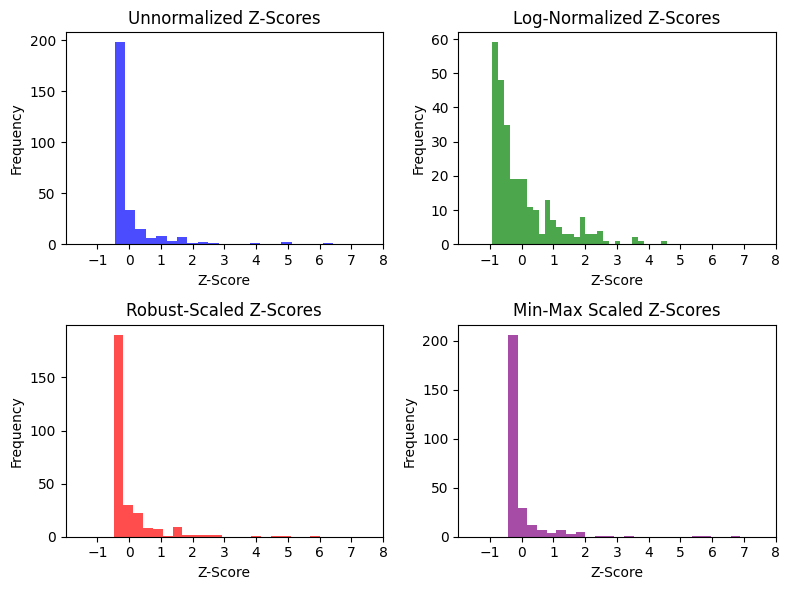

In [53]:
import matplotlib.pyplot as plt 

# Get z-scores
scores = {
    'Unnormalized': unnormalized_final_scores["z_score"],
    'Log-Normalized': log_normalized_final_scores["z_score"],
    'Robust-Scaled': robust_scaled_final_scores["z_score"],
    'Min-Max Scaled': minmax_scaled_final_scores["z_score"], 
}

colors = ['blue', 'green', 'red', 'purple']
fig, axes = plt.subplots(2,2, figsize=(8,6))  # Create subplots

# Flatten axes to iterate properly over a 2D array
axes = axes.ravel() 

# Plot histograms
for i, (title, data) in enumerate(scores.items()):
    axes[i].hist(data, bins=30, color=colors[i], alpha=0.7)
    axes[i].set_xlim(-2, 8)
    axes[i].set_xticks(list(range(-1, 9)))  # Convert to a list for safety
    axes[i].set_title(f'{title} Z-Scores')
    axes[i].set_xlabel('Z-Score')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# **Choosing Between Log Normalization and Robust Scaling**

### **1️. Understanding the Differences Between Log and Robust Scaling**
| **Method** | **How It Works** | **Best For** | **Impact on Outliers** |
|------------|----------------|--------------|--------------------------|
| **Log Normalization (`np.log1p`)** | Reduces the effect of large values by compressing high values more than low values | **Right-skewed distributions** (like ours) | **Reduces the impact of outliers but still keeps them in the distribution** |
| **Robust Scaling** | Centers data using the median and scales based on the interquartile range (IQR) | **Data with many outliers and a skewed distribution** | **Ignores extreme values (values beyond IQR, are NOT used for scaling), making outliers less impactful** |

---

### **2️. Key Observations from our Results**
- **Both methods give similar high-scoring users, but log normalization includes slightly more users in the z-score > 2 category.**
- **This suggests that log normalization is more sensitive to distinguishing users with slightly higher activity levels, while robust scaling is stricter in filtering out extreme values.** 

---

### Conclusion:
If we **want to identify all high-engagement users**, choose **log normalization**.  
If we **prefer a stricter definition of ‘power users'**, choose **robust scaling**.  

## **Interpretation of the plots:**

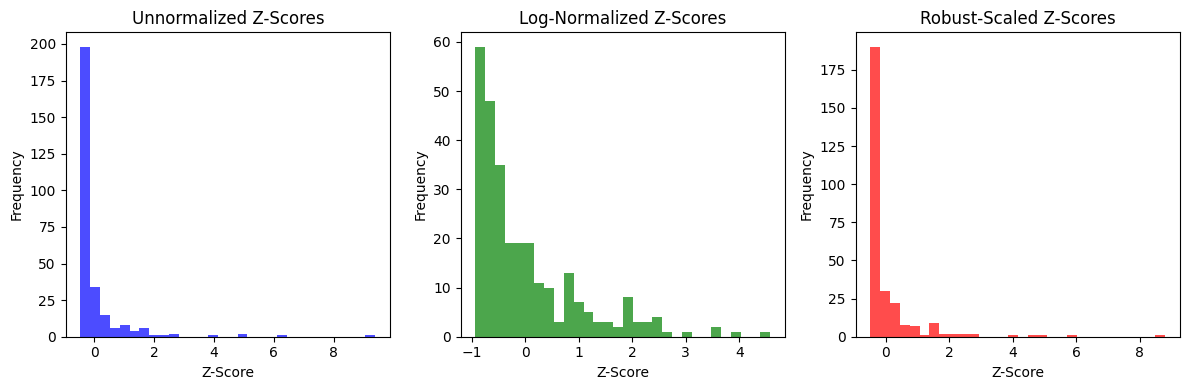

### **1️⃣ Unnormalized Z-Scores (First Plot - Blue)**
- The distribution is heavily **right-skewed**, meaning most users have **low scores**, while a few users have **extremely high scores**.
- There are **a lot of outliers** (users with high scores), which can distort the analysis if not handled properly.
- The extreme values could dominate any ranking system, making it difficult to fairly compare users.

---

### **2️⃣ Log-Normalized Z-Scores (Second Plot - Green)**
- The distribution is **much more balanced** compared to the first plot.
- The log transformation **compressed high values**, reducing the impact of extreme outliers.

🛠 **Key Insight:**  
Log normalization **reduces the impact of large variations** and **makes differences between users more meaningful**.

---

### **3️⃣ Robust-Scaled Z-Scores (Third Plot - Red)**
- The shape is **still right-skewed**, but **less extreme than the first plot**.
- Since RobustScaler is based on **median and IQR**, it effectively **resisted the influence of extreme outliers in calculations**.
- Unlike log transformation, this method **does not compress high values as much**, so some extreme users **still have large scores**.
- It does **not assume normality** and is better suited for ranking users **without distorting differences in engagement**.

🛠 **Key Insight:**  
Robust Scaling **maintains the relative ranking of users while reducing the impact of outliers**.